In [1]:
# load packages
import os
import glob
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import backend
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# path of model checkpoints
checkpoint_path = '../../../data/models/20201021_unrestr_gaussian_resampled'
shard_path = '../../../data/commaai/training_files/unrestricted_gauss_dens_resampled'
shard_files = glob.glob(os.path.join(shard_path, "*.tfrecords")) 

In [3]:
val_angles_path = '../../../data/commaai/test_files/yaws.csv'
val_angle = pd.read_csv(val_angles_path, header = None)
val_files = ['../../../data/commaai/test_files/_test.tfrecords']

In [4]:
#checkpoint_path = '../../../data/models/20201021_unrestr_gaussian_resampled/model.ckpt-74000'

In [5]:
# or thresholded relative error?
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.5)(x)
x = Dense(50)(x) 
x = Dropout(0.2)(x)
x = Dense(10)(x)
Output = Dense(1, name = 'output_layer')(x)

keras_model = tf.keras.models.Model(
      inputs = [Input], outputs = [Output])

keras_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) # tf.train.latest_checkpoint(checkpoint_path)

def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

adam_optimizer = keras.optimizers.Adam(learning_rate=0.00025)
# old
#keras.optimizers.Adadelta(learning_rate = 0.001, rho = 0.95, epsilon = 1e-07, name = 'Adadelta')
keras_model.compile(
    loss = 'mse',
    optimizer = adam_optimizer,
    metrics=[rmse, 'mse', 'mae'])

keras_estimator = tf.keras.estimator.model_to_estimator(
      keras_model=keras_model, model_dir = checkpoint_path)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '../../../data/models/20201021_unrestr_gaussian_resampled', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
def imgs_input_fn_val(filenames, perform_shuffle = False, repeat_count = 1, batch_size = 500): 
    
    # reads in single training example and returns it in a format that the estimator can
    # use
    def _parse_function(proto):
        # define your tfrecord again. Remember that you saved your image as a string.
        keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                            'label': tf.io.FixedLenFeature([], tf.float32),
                            'rows': tf.io.FixedLenFeature([], tf.int64),
                            'cols': tf.io.FixedLenFeature([], tf.int64),
                            'depth': tf.io.FixedLenFeature([], tf.int64),
                            'tr_label': tf.io.FixedLenFeature([], tf.float32)
                           }

        # Load one example
        parsed_example = tf.io.parse_single_example(proto, keys_to_features)

        image_shape = tf.stack([874, 1164, 4])
        image_raw = parsed_example['image']

        label = tf.cast(parsed_example['label'], tf.float32)
        tr_label = tf.cast(parsed_example['tr_label'], tf.float32)
        image = tf.io.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)

        image = tf.reshape(image, image_shape)
        image = tf.image.resize(image, [218, 291])[76:142, 45:245,0:3]
        image = image/255 

        return {'image':image}, tr_label
    
    dataset = tf.data.TFRecordDataset(filenames = filenames)
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    batch_features, batch_labels = iterator.get_next()
    
    return batch_features, batch_labels

In [15]:
images = []
labels = []
for i in range(0,1):
    image, label = imgs_input_fn_val(shard_files)
    image = np.array(image['image'])
    images.append(image)
    labels.append(np.array(label))
images = np.array(images)
labels = np.array(labels)

In [16]:
pred = []
for i in tqdm(range(0, images.shape[1])):
    img = images[0,i,:,:,:].reshape(1,66,200, 3)
    single_pred = float(keras_model.predict(img))
    pred.append(single_pred)

100%|██████████| 500/500 [00:53<00:00,  9.39it/s]


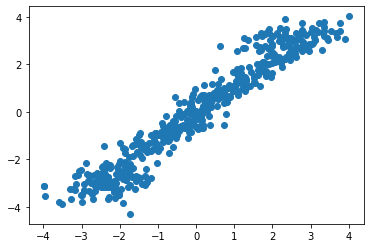

In [17]:
plt.scatter(pred, labels)

In [10]:
images.shape

(1, 100, 66, 200, 3)

In [11]:
import sys

In [12]:
sys.getsizeof(images)

15840160

In [13]:
15840160/1000

15840.16